In [1]:
from neural_priors.utils.plotting import plot_prf_predictions
from neural_priors.utils.data import Subject, get_all_subject_ids, get_all_behavioral_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
from scipy import stats, odr
from braincoder.models import LogGaussianPRF, GaussianPRF

In [2]:
plt.rcParams['legend.frameon'] = False
np.set_printoptions(linewidth=140)
pd.set_option('display.width', 170) # 80
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 70)

In [3]:
bids_folder = '../../ds-neuralpriors'

2024-05-28 10:34:31.304812: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')


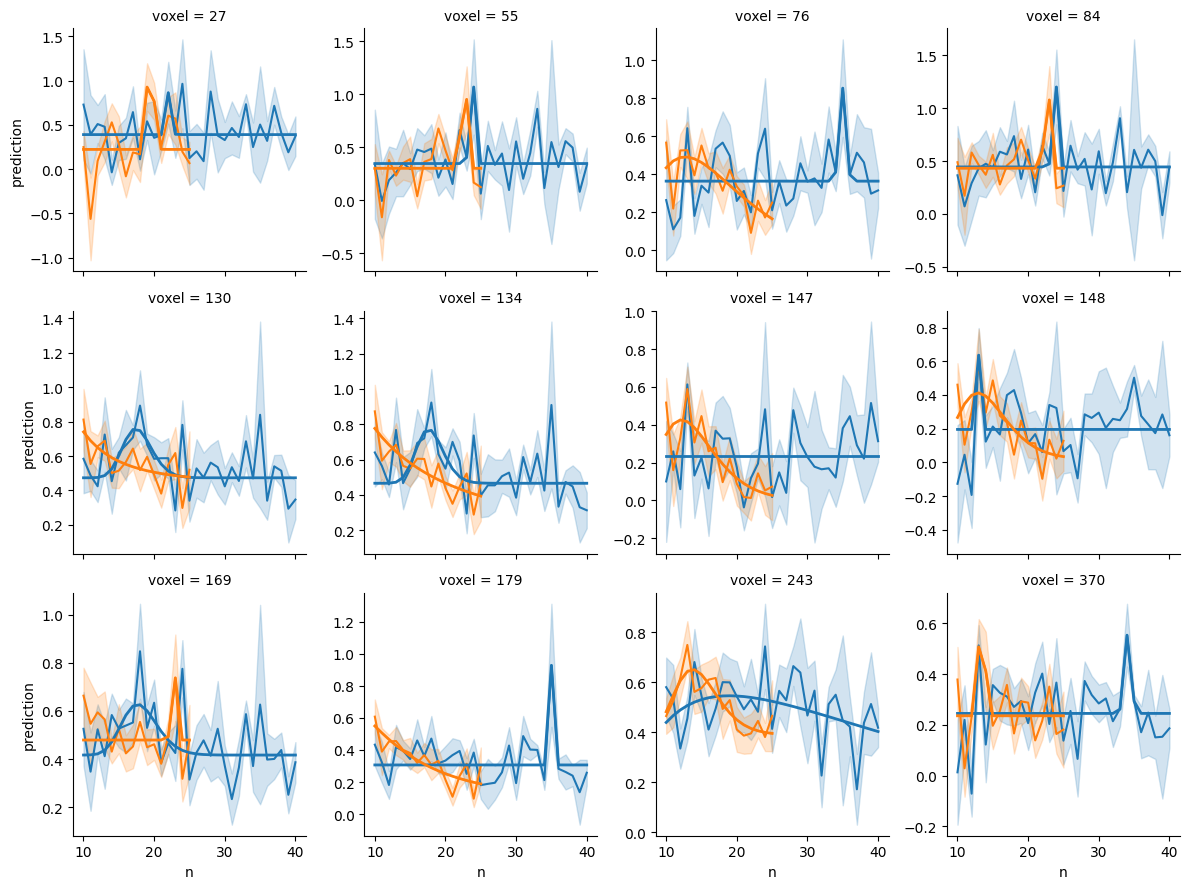

In [4]:
plot_prf_predictions('10', bids_folder=bids_folder)

In [5]:
get_all_subject_ids()

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '24']

In [6]:
behavior = get_all_behavioral_data(bids_folder=bids_folder) #, subjects=[f'{i}'.rjust(2,'0') for i in range(1,23)])

In [7]:
behavior

onset  phase  response  nr_frames     n  jitter  start_marker_position  response_time   onset_abs  duration   range  error  \
subject session run trial_nr                                                                                                                                    
01      1       1   1          68.826307      5       NaN       30.0  11.0     6.0                   24.0            NaN   76.378611  0.500457  narrow    NaN   
                    2          76.016292      5      19.0       31.0  23.0     4.0                   14.0       1.317963   83.568595  0.517188  narrow   -4.0   
                    3          87.026471      5      25.0       30.0  23.0     6.0                   11.0       0.834244   94.578775  0.500469  narrow    2.0   
                    4          97.085656      5      24.0       30.0  22.0     5.0                   22.0       1.701381  104.637959  0.500559  narrow    2.0   
                    5         106.744768      5      17.0       31.0  21.0     5.0                   22.0       2.018881  114.297072  0.517009  narrow   -4.0   
...                                  ...    ...       ...        ...   ...     ...                    ...            ...         ...       ...     ...    ...   
24      2       8   26        279.957096      5      24.0       31.0  13.0     5.0                   25.0       1.385050  283.025374  0.517056    wide   11.0   
                    27        290.900569      5      15.0       30.0  11.0     6.0                   15.0       1.317862  293.968847  0.500460    wide    4.0   
                    28        302.160998      5      27.0       30.0  12.0     6.0                   16.0       1.083384  305.229276  0.500410    wide   15.0   
                    29        312.203573      5      23.0       30.0  39.0     6.0                   14.0       1.468224  315.271851  0.500535    wide  -16.0   
                    30        321.662398      5      25.0       30.0  21.0     5.0                   31.0       1.184674  324.730676  0.500440    wide    4.0   

                              abs_error  squared_error  
subject session run trial_nr                            
01      1       1   1               NaN            NaN  
                    2               4.0           16.0  
                    3               2.0            4.0  
                    4               2.0            4.0  
                    5               4.0           16.0  
...                                 ...            ...  
24      2       8   26             11.0          121.0  
                    27              4.0           16.0  
                    28             15.0          225.0  
                    29             16.0          256.0  
                    30              4.0           16.0  

[10560 rows x 14 columns]

In [8]:
from tqdm.contrib.itertools import product

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
load_data_via_tsv = True

if load_data_via_tsv:
    df = pd.read_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t',
                    index_col=[0, 1, 2, 3, 4, 5,],
                    dtype={'subject':str})
    df.columns.name = 'parameter'
    df.index.set_names('voxel', level=-1, inplace=True)
else:
    df = []
    keys = []
    subjects = [f'{subject:02d}' for subject in range(1, 11)]
    #subjects.pop(subjects.index('11'))
    #subjects.pop(subjects.index('16'))

    for subject, range_n, session, smoothed, gaussian in product(subjects, ['wide', 'narrow', None, 'wide2'], [None], [True, False], [False, True]):
    # for subject, range_n, session, smoothed in product(subjects, ['wide', 'narrow', None], [None], [True, False]):
        sub = Subject(subject, bids_folder)
        sub_df = sub.get_prf_parameters_volume(session=session, cross_validated=False, roi='NPCr', smoothed=smoothed, range_n=range_n, gaussian=gaussian)
        if gaussian:
            sub_df = sub_df.rename(columns={'mu':'mode', 'sd':'width'})
        else:
            sub_df = sub_df.rename(columns={'fwhm':'width'})
        df.append(sub_df)
        keys.append((subject,
                    range_n if range_n is not None else 'both', session if session is not None else 'both',
                    'smoothed' if smoothed else 'unsmoothed',
                    'gaussian' if gaussian else 'lognormal'))

    df = pd.concat(df, keys=keys, names=['subject', 'range_n', 'session', 'smoothed', 'model'])
    df.to_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t')

df = df.unstack(['range_n', 'model', ]).reorder_levels(axis='columns', order=['model', 'parameter', 'range_n'])
df = df.sort_index(axis=1, level=['model'], sort_remaining=False)

In [10]:
df

model                              gaussian                                                                                                                       \
parameter                              mode                                       width                                 amplitude                                  
range_n                                wide     narrow       both      wide2       wide     narrow       both     wide2      wide     narrow      both     wide2   
subject session smoothed   voxel                                                                                                                                   
01      both    smoothed   0      37.331580  21.130262  37.328106  11.521615   0.380676   0.393754   0.369219  0.903927  1.185430   0.684489  1.154732  0.730819   
                           1      33.823980   1.494949  33.827130  11.690054   0.691515   0.930751   0.669060  0.470582  0.749141   1.000000  0.721397  1.063844   
                           2      28.570770  11.896837  28.571964  15.474047   0.455065   0.934176   0.441089  1.315536  0.879009   0.328444  0.838193  0.488743   
                           3      15.578845  12.634643  15.078586  15.590552   1.232632   2.400479   1.201911  1.414796  0.484702   0.272002  0.293433  0.609456   
                           4      11.837032   1.494949  11.579186  11.841673   0.780043   0.930751   1.052789  0.820361  0.961507   1.000000  0.375331  1.067047   
...                                     ...        ...        ...        ...        ...        ...        ...       ...       ...        ...       ...       ...   
24      both    unsmoothed 492    38.960663  16.037647  39.420630  21.221690  27.030067   0.435537   0.574254  0.768259  1.212309   0.729678  0.846027  0.657063   
                           493    42.917103  31.191920  39.522182  14.672663   9.241786   0.677690   0.456291  0.429556  0.414750   1.000000  0.860770  0.736108   
                           494    50.160430  15.259594  50.733070  22.312862  26.523380   0.259572  24.495544  0.382103  0.550941   0.582908  0.363870  0.726376   
                           495    12.138888  60.592590  28.151442  12.118049   0.295219  13.348577   0.285401  0.278124  2.149490  12.189654  1.324293  2.076687   
                           496    11.848743  20.550999  11.600238  11.915381   0.278168   0.287504   0.409443  0.258588  2.085903   2.617463  0.971867  1.841121   

model                                                                                                                                                         lognormal  \
parameter                         baseline                                      r2                                        cvr2                                     mode   
range_n                               wide    narrow      both     wide2      wide        narrow      both     wide2      wide    narrow      both     wide2       wide   
subject session smoothed   voxel                                                                                                                                          
01      both    smoothed   0     -0.130047 -0.100742 -0.096932 -0.242528  0.025201  2.050865e-02  0.013216  0.031572 -0.010708 -0.032013 -0.014043 -0.150754  37.329970   
                           1     -0.531587 -0.480002 -0.504918 -0.642029  0.021125  6.556511e-07  0.011212  0.036704 -0.077139 -0.059341 -0.039218 -0.112296  33.805660   
                           2     -0.533938 -0.502003 -0.494765 -0.664763  0.028484  1.959437e-02  0.015086  0.043335 -0.078357 -0.051230 -0.041021 -0.139205  28.579900   
                           3     -0.345751 -0.334168 -0.312876 -0.462194  0.027097  2.759850e-02  0.014950  0.070238 -0.087892 -0.035467 -0.061280 -0.090636  15.417759   
                           4     -0.108688 -0.084063 -0.110316 -0.199107  0.027147  3.576279e-07  0.008204  0.050542 -0.059541 -0.024274 -0.040139 -0.099978  11.764649   


Text(0.5, 1.0, 'cvr2, narrow')

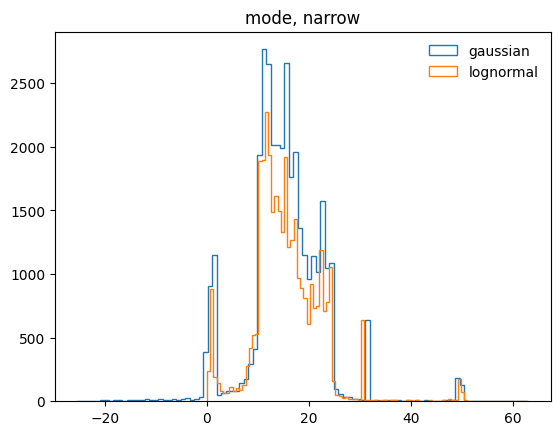

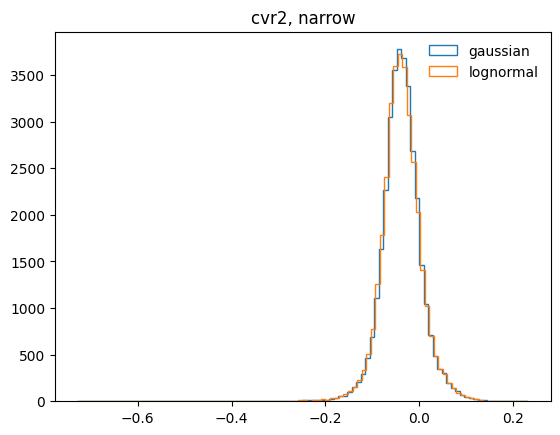

In [11]:
plt.hist( df['gaussian', 'mode', 'narrow'], histtype='step', bins=100, label='gaussian');
plt.hist( df['lognormal', 'mode', 'narrow'], histtype='step', bins=100, label='lognormal');
plt.legend();
plt.title('mode, narrow')
plt.figure()
plt.hist( df['gaussian', 'cvr2', 'narrow'], histtype='step', bins=100, label='gaussian');
plt.hist( df['lognormal', 'cvr2', 'narrow'], histtype='step', bins=100, label='lognormal');
plt.legend();
plt.title('cvr2, narrow')

In [12]:
df.xs(key=('cvr2','wide'), axis=1, level=('parameter','range_n') )

model                             gaussian  lognormal
subject session smoothed   voxel                     
01      both    smoothed   0     -0.010708  -0.010168
                           1     -0.077139  -0.077566
                           2     -0.078357  -0.078185
                           3     -0.087892  -0.083928
                           4     -0.059541  -0.054619
...                                    ...        ...
24      both    unsmoothed 492   -0.021902  -0.025399
                           493   -0.096580  -0.098383
                           494   -0.072591  -0.072641
                           495   -0.083057  -0.079263
                           496   -0.006356  -0.022222

[34572 rows x 2 columns]

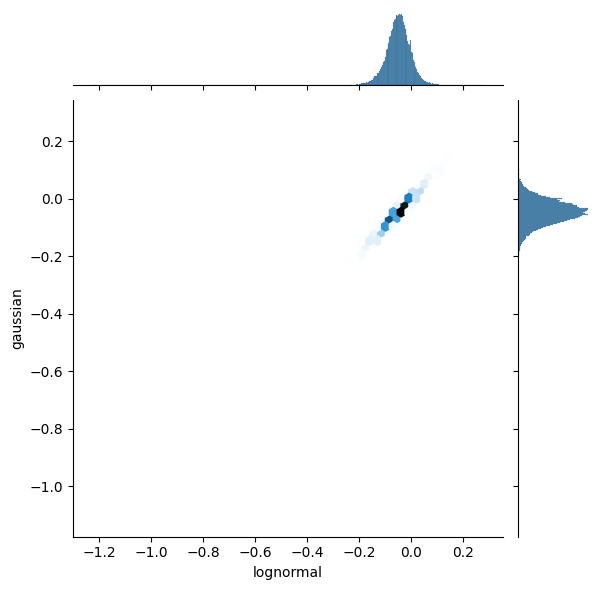

In [13]:
sns.jointplot(data=df.xs(key=('cvr2','wide'), axis=1, level=('parameter','range_n') ), x='lognormal', y='gaussian', kind='hex')

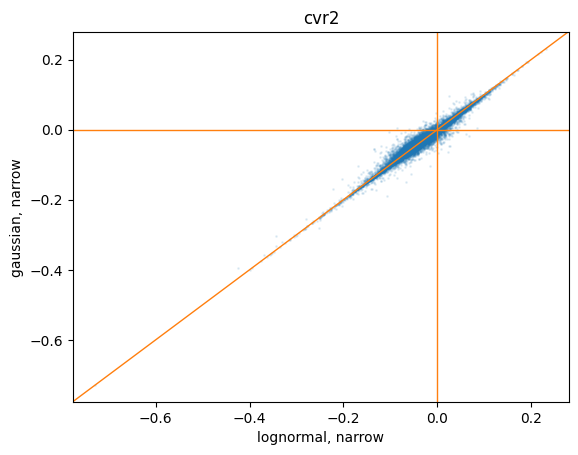

In [14]:
#sns.scatterplot(data=df.xs('cvr2', axis=1, level='parameter'), x='lognormal', y='gaussian', hue='range_n')
plt.scatter(df['lognormal', 'cvr2', 'narrow'], df['gaussian', 'cvr2', 'narrow'], s=1, alpha=.1);
plt.xlabel('lognormal, narrow'); plt.ylabel('gaussian, narrow')
plt.title('cvr2')
plt.axline((0,0), slope=1, c='C1', lw=1)
plt.axhline(0, c='C1', lw=1)
plt.axvline(0, c='C1', lw=1)

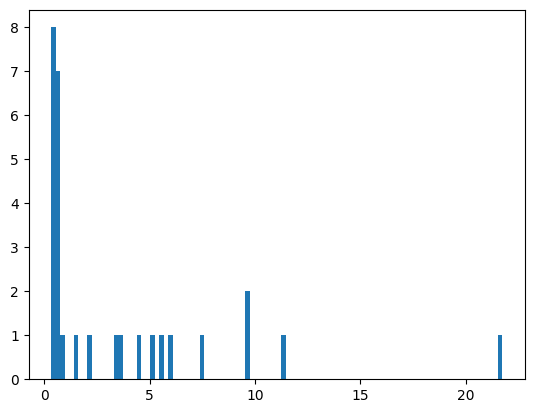

In [15]:
# doing good with lognormal but not with gaussian 
# and have (lognormal) mode in the range
mask = (df[('lognormal', 'cvr2', 'narrow')] > 0.01) & (df[('gaussian', 'cvr2', 'narrow')] < 0.0)
mask &= (df[('lognormal', 'mode', 'narrow')] >= 12 ) & (df[('lognormal', 'mode', 'narrow')] <= 23 )
plt.hist( df[mask][('gaussian','amplitude','narrow')], bins=100);

In [16]:
df[mask][('gaussian','amplitude','narrow')].shape

(29,)

In [17]:
np.mean( df[mask][('gaussian','amplitude','narrow')].values <= 0.001 )

0.0

In [18]:
df[mask]

model                              gaussian                                                                                                                         \
parameter                              mode                                       width                                  amplitude                                   
range_n                                wide     narrow       both      wide2       wide     narrow       both      wide2      wide     narrow      both      wide2   
subject session smoothed   voxel                                                                                                                                     
02      both    unsmoothed 293    33.820713  17.847359  17.890223  16.494738   0.639532   1.364408   1.351420   0.272403  1.185221   0.583301  0.503056   1.402647   
                           732    36.549362  17.146328  18.767328  18.993044   0.351527   3.185596   0.299907   0.185909  1.487064   0.626858  0.903246   0.529798   
03      both    unsmoothed 184    18.437744  19.697002  25.931122  18.455156   0.354161  25.259682  26.295877   0.304323  1.148649   9.534781  2.410486   1.669322   
04      both    smoothed   186    14.070024  14.475554  14.725328  10.938383  25.943985   3.309498   3.813830   0.254806  0.749168   0.334816  0.249578   0.313297   
                unsmoothed 525     9.912246  13.523008  11.515752  10.059387   3.791500   8.063244   4.246131   3.501136  0.876448   0.701858  0.487052   0.828888   
05      both    smoothed   151    38.022820  19.113047  15.666330  23.689371   0.263559  23.937998   1.571438   0.707622  0.380778   3.382588  0.164400   0.282427   
06      both    smoothed   103    28.802282  16.766150  14.433730  23.603764   0.335005  23.985487   0.372061   0.334677  0.351540   5.543324  0.448696   0.492086   
                           134    29.376953  17.039816  14.167944   1.494949   0.419411  23.796398   0.875635   0.930751  0.306389   3.659702  0.149174   1.000000   
                           464    24.056684  14.965997  11.380342  20.578709   4.797257   9.935510  25.989847   0.359898  0.120003   0.468353  0.216396   0.240145   
08      both    unsmoothed 224    32.502850  20.015629  32.502934   1.494949   0.372437  26.479092   0.371928   0.930751  0.859827   5.252136  0.832663   1.000000   
12      both    smoothed   538    22.368898  15.043270  16.216356  22.998676   4.566837   5.791988   2.278902  26.029379  0.343085   0.549248  0.205641   4.928160   
                           539    22.917260  15.268933  16.542547  24.452730   4.044125   5.754681   2.250800  25.937860  0.252536   0.457469  0.152292   3.374503   
13      both    smoothed   98     11.991742  13.091886  11.064981   3.985347  10.051481   3.461980   8.882971  11.060564  0.580865   0.355526  0.494663   0.394232   
16      both    smoothed   503    27.583563  13.994654  13.981248  10.964562   1.476124   0.255089   0.272303   0.255320  0.290621   0.588226  0.362726   0.261517   
17      both    smoothed   145    10.470137  13.428443   7.862478  10.472103   0.378155   6.479622   7.430944   0.342315  0.824031   0.395914  0.243066   0.873691   
18      both    unsmoothed 690    20.143412  16.559624  19.640840  20.124317   0.731860   4.641061   0.359003   0.744035  0.675302   0.821855  0.713590   0.690623   
                           707    24.330513  17.686232  18.018300  24.417618   0.732157  14.306332   3.444905   0.806282  0.746568   5.912937  0.340614   0.671296   
20      both    smoothed   158    27.333769  16.401157  16.962700  18.906370   0.341406  24.316750   3.045185   4.974475  0.865796  11.453383  0.259715   0.339755   
                           204    14.298384  17.460280  16.110178  14.293417   1.397429   5.302137   2.653625   1.427988  0.238948   0.406806  0.169187   0.246407   
                           584    27.330914  15.103295  27.368359  24.387184   0.749519   0.543845   0.683067   0.715674  0.737171   0.580925  0.755720   0.359449   
                

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')


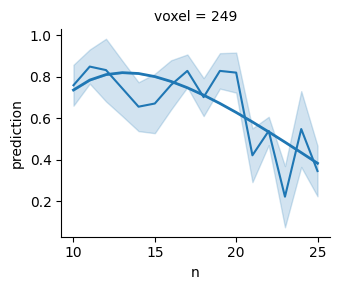

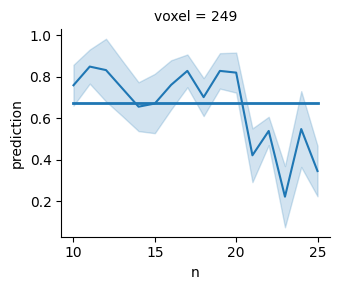

In [19]:
plot_prf_predictions('01', bids_folder=bids_folder, voxels=[249,], range_n='narrow')
plot_prf_predictions('01', bids_folder=bids_folder, voxels=[249,], range_n='narrow', gaussian=True)

In [27]:
from scipy import optimize

In [41]:
import braincoder
braincoder.__path__ 

['/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/braincoder']

[10.   1.  -0.7] 0.5704673475388361
[10.00000001  1.         -0.7       ] 0.5704673471592858
[10.          1.00000001 -0.7       ] 0.5704673347811888
[10.          1.         -0.69999999] 0.5704673324476554
[10.01920339  1.64547475  0.06354016] 0.3089284166817001
[10.0192034   1.64547475  0.06354016] 0.30892841709802216
[10.01920339  1.64547476  0.06354016] 0.308928426162032
[10.01920339  1.64547475  0.06354017] 0.308928427702033
[10.00876201  1.37030497 -0.25870261] 0.0008722264735801436
[10.00876202  1.37030497 -0.25870261] 0.0008722264537856285
[10.00876201  1.37030498 -0.25870261] 0.0008722265232590614
[10.00876201  1.37030497 -0.2587026 ] 0.0008722264244057287
[10.00933766  1.36885423 -0.25727409] 0.0008569753701350716
[10.00933767  1.36885423 -0.25727409] 0.0008569753506970433
[10.00933766  1.36885424 -0.25727409] 0.0008569754228759069
[10.00933766  1.36885423 -0.25727408] 0.0008569753256082807
[10.01164022  1.36305128 -0.25156001] 0.0007983714105605971
[10.01164023  1.36305128 -

(0.0, 1.35)

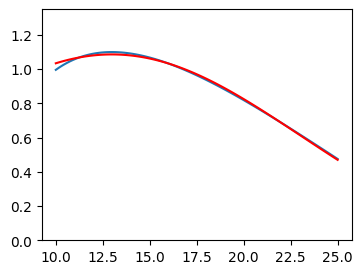

In [28]:
plt.figure(figsize=(4,3))
xxx = np.linspace(10,25,100)
model = LogGaussianPRF(parameterisation='mode_fwhm_natural')
yyy = model.predict(xxx, parameters=pd.DataFrame(data=[[12.98,60.29,5.55,-4.45],], columns=['mode', 'fwhm', 'amplitude', 'baseline']) ).values.flatten()
plt.plot(xxx, yyy)
#plt.plot(xxx, model.predict(xxx, parameters=pd.DataFrame(data=[[12.5,33,1,-0.7],], columns=['mode', 'fwhm', 'amplitude', 'baseline']) ) )
def objf(x):
    σ, a, b = x
    zzz = b + a*np.exp(-.5*((xxx-12.98)/σ)**2)
    r = ((zzz-yyy)**2).mean()
    print(x,r)
    return r
res = optimize.minimize(objf, x0=[10, 1, -.7], bounds=[(0.,None), (0.,None), (None,None)])
_σ, _a, _b = res.x
print(res.x)
plt.plot(xxx, _b + _a*np.exp(-.5*((xxx-12.98)/_σ)**2), c='r')
#plt.plot(xxx, -.7 + 1*np.exp(-.5*((xxx-12.5)/10)**2), ls='--')
plt.ylim(0,1.35)

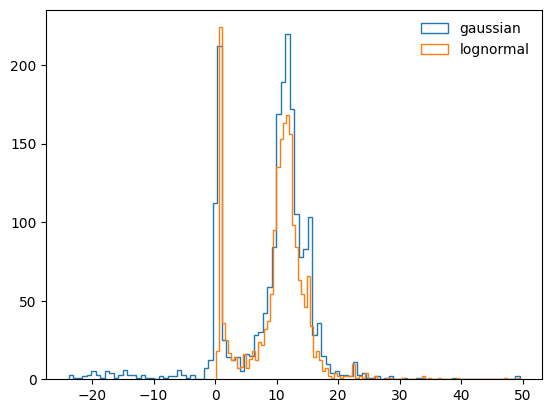

In [21]:
mask = (df[[('gaussian', 'cvr2', 'wide'), ('gaussian', 'cvr2', 'narrow')]].mean(1) > 0.01)
#mask &= (df[('gaussian', 'mode', 'narrow')] >= 10)
plt.hist( df[mask]['gaussian', 'mode', 'narrow'], histtype='step', bins=100, label='gaussian');
plt.hist( df[mask]['lognormal', 'mode', 'narrow'], histtype='step', bins=100, label='lognormal');
plt.legend();

In [22]:

logn_model = LogGaussianPRF(parameterisation='mode_fwhm_natural')

In [23]:
import itertools

In [27]:
from scipy import optimize

In [28]:
def min_objf(f, x0s, v=False, **kwargs):
    bestF = np.inf
    bestRes = None
    for x0 in x0s:
        res = optimize.minimize(f, x0=x0, **kwargs)
        if v:
            print(x0, '->', res.x, res.fun)
        if res.fun < bestF:
            bestF = res.fun
            bestRes = res
    return bestRes

In [29]:
def optimize_gaussian_params(logn_pars, range_n, return_preds=False):
    xxx = np.linspace(10,{'narrow':25, 'wide':40}[range_n],100)
    yyy = logn_model.predict(xxx, parameters=pd.DataFrame(data=[logn_pars,], columns=['mode', 'fwhm', 'amplitude', 'baseline']) ).values.flatten()
    mode = logn_pars[0]
    def objf(x):
        σ, a, b = x
        zzz = b + a*np.exp(-.5*((xxx-mode)/σ)**2)
        r = ((zzz-yyy)**2).mean()
        #print(x, r)
        return r
    res = min_objf(objf, x0s=itertools.product([1,5,10,15,20,25], [.1, 1], [-.7, 0, .7]), v=False, bounds=[(1e-8,None), (0.,None), (None,None)])
    #res = min_objf(objf, x0s=[[10,1,-.7],], v=True, bounds=[(0.,None), (0.,None), (None,None)])
    #optimize.minimize(objf, x0=[10, 1, -.7], bounds=[(0.,None), (0.,None), (None,None)])
    if not res.success:
        print(res)
    if return_preds:
        σ, a, b = res.x
        zzz = b + a*np.exp(-.5*((xxx-mode)/σ)**2)
        return res.x, xxx, yyy, zzz
    return res.x

[8.82627711 1.00320057 0.08715013]


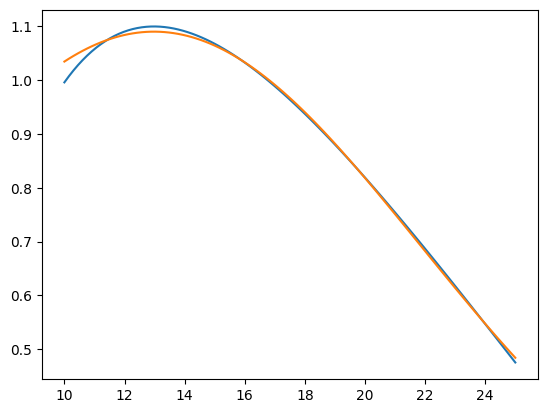

In [30]:
pars, xxx, yyy, zzz = optimize_gaussian_params( [12.98,60.29,5.55,-4.45], 'narrow', return_preds=True)
print(pars)
plt.plot(xxx, yyy)
plt.plot(xxx, zzz)

In [31]:
# doing good with lognormal but not with gaussian 
# and have (lognormal) mode in the range
mask = (df[('lognormal', 'cvr2', 'narrow')] > 0.01) #& (df[('gaussian', 'cvr2', 'narrow')] < 0.0)
mask &= (df[('lognormal', 'cvr2', 'wide')] > 0.01) #& (df[('gaussian', 'cvr2', 'wide')] < 0.0)
mask &= (df[('lognormal', 'mode', 'narrow')] >= 10 ) & (df[('lognormal', 'mode', 'narrow')] <= 25 )
mask &= (df[('lognormal', 'mode', 'wide')] >= 10 ) & (df[('lognormal', 'mode', 'wide')] <= 40 )
## select both the narrow and wide range_n
tmp = df[mask]['lognormal'].xs('smoothed', 0, 'smoothed').loc[:, (['mode', 'width', 'amplitude', 'baseline'], ['narrow', 'wide'])]
tmp = tmp.swaplevel('parameter', 'range_n', axis=1)
tmp['wide']

parameter                   mode      width  amplitude  baseline
subject session voxel                                           
02      both    76     14.174344  21.998398   0.532330 -0.285473
                79     12.116240  60.381298   1.383201 -1.049156
                101    14.315305  59.780937   1.173265 -0.982491
                103    13.671444  60.515724   1.349455 -0.939614
                107    14.145712  60.229057   1.134404 -0.784952
...                          ...        ...        ...       ...
22      both    119    21.395523  59.513980   1.485066 -1.289170
                526    10.761586  60.447083   1.293683 -0.921000
                630    10.552200  17.629562   0.426283 -0.001795
                860    24.288986  20.553772   0.477506 -0.352238
24      both    8      24.368921   0.764639   1.477126 -0.030817

[335 rows x 4 columns]

In [32]:
gaussian_pars_narrow = tmp.apply(lambda x: pd.Series( optimize_gaussian_params(x['narrow'].values, 'narrow'), index=['width', 'amplitude', 'baseline']) , axis=1)
gaussian_pars_wide = tmp.apply(lambda x: pd.Series( optimize_gaussian_params(x['wide'].values, 'wide'), index=['width', 'amplitude', 'baseline']) , axis=1)

In [33]:
# combine gaussina_pars_narrow and gaussian_pars_wide
gaussian_pars = pd.concat([gaussian_pars_narrow, gaussian_pars_wide], axis=1, keys=['narrow', 'wide'])
gaussian_pars

narrow                           wide                    
                          width amplitude  baseline      width amplitude  baseline
subject session voxel                                                             
02      both    76     8.867388  0.746440 -0.481360  10.254276  0.398371 -0.165317
                79     8.824712  0.730692 -0.394600  14.029848  0.465170 -0.140739
                101    8.821567  0.643267 -0.413935  14.081892  0.390039 -0.207134
                103    8.785227  0.635053 -0.209451  14.069929  0.446462 -0.045146
                107    8.894152  0.424793 -0.064918  14.087465  0.375223 -0.033194
...                         ...       ...       ...        ...       ...       ...
22      both    119    4.218193  0.373762 -0.119269   6.484979  0.262559 -0.056237
                526    6.563525  0.663439 -0.214376  14.094160  0.440252 -0.079677
                630    8.900629  0.686848 -0.221743   9.364384  0.345221  0.062884
                860    4.253505  0.465923 -0.335819   6.834201  0.397732 -0.264378
24      both    8      0.313225  1.044911 -0.074015   0.324684  1.477125 -0.030812

[335 rows x 6 columns]

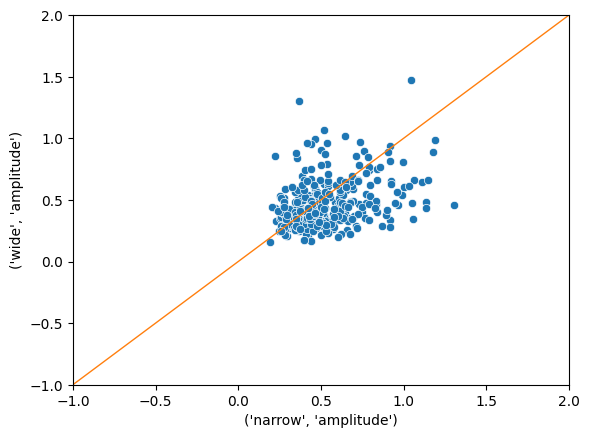

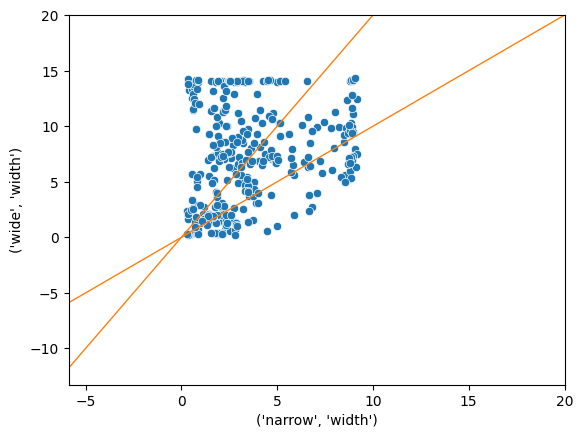

In [40]:
sns.scatterplot(data=gaussian_pars, x=('narrow','amplitude'), y=('wide','amplitude'), ) #kind='hex', joint_kws=dict(gridsize=30))
plt.axline((0,0), slope=1, c='C1', lw=1)
plt.xlim(-1,2); plt.ylim(-1,2); 
plt.figure()
sns.scatterplot(data=gaussian_pars, x=('narrow','width'), y=('wide','width'), ) #kind='hex', joint_kws=dict(gridsize=30))
plt.axline((0,0), slope=1, c='C1', lw=1)
plt.axline((0,0), slope=2, c='C1', lw=1)
plt.xlim(None, 20); plt.ylim(None, 20); 

In [41]:
for c in df['mode'].columns:

    mode = df[('mode', c)]
    fwhm = df[('fwhm', c)]

    df[('log_sigma', c)] = 1./(np.sqrt(2.*np.log(2.))) * np.arcsinh(fwhm/(mode*2.))
    df[('log(mode)', c)] = np.log(mode)

KeyError: 'mode'

In [42]:
tmp = df.stack('range_n')
tmp = tmp[tmp.cvr2 > 0.01]
sns.jointplot(x='log(mode)', y='log_sigma', data=tmp.reset_index(), kind='hex')

/var/folders/jq/_79_qpxx3vd0thkqqmw37l1c0000gn/T/ipykernel_54575/267291279.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tmp = df.stack('range_n')


AttributeError: 'DataFrame' object has no attribute 'cvr2'